# TP 4: Improve the Metropolis-Hastings algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import pandas as pd
import seaborn as sns

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

#### 1.

On commence par implémenter un algorithme qui permet d'échantillonner la distribution $P_1$, puis $P_2$ et enfin, on les utilise pour échantillonner une chaîne de Markov dont le noyaux est $P$.

In [2]:
def log_pi(x, y, a):
    return (-(x / a)**2 - y**2 - (1 / 4) * ((x / a)**2 - y**2)**2)


def sample_pi1(x0, y0, sigma, a):
    x_proposal = stat.norm.rvs(loc=x0, scale=sigma[0])

    log_pi_current = log_pi(x0, y0, a)
    log_pi_proposal = log_pi(x_proposal, y0, a)
    log_alpha = min(0, log_pi_proposal - log_pi_current)
    U = np.random.random()
    if (np.log(U) <= log_alpha):
        return x_proposal, True
    else:
        return x0, False


def sample_pi2(x0, y0, sigma, a):
    y_proposal = stat.norm.rvs(loc=y0, scale=sigma[1])

    log_pi_current = log_pi(x0, y0, a)
    log_pi_proposal = log_pi(x0, y_proposal, a)
    log_alpha = min(0, log_pi_proposal - log_pi_current)
    U = np.random.random()
    if (np.log(U) <= log_alpha):
        return y_proposal, True
    else:
        return y0, False


def sample_pi(x0, y0, sigma, a, Niter, alpha):
    x = np.zeros(Niter + 1)
    y = np.zeros(Niter + 1)

    nb_acc_x = 0
    nb_acc_y = 0

    list_acc_x = []
    list_acc_y = []

    for i in range(Niter):
        u = np.random.random()
        if u <= alpha:
            x[i + 1], acc = sample_pi1(x[i], y[i], sigma, a)
            y[i + 1] = np.copy(y[i])
            if acc: nb_acc_x += 1
        else:
            y[i + 1], acc = sample_pi2(x[i], y[i], sigma, a)
            x[i + 1] = np.copy(x[i])
            if acc: nb_acc_y += 1

        if (i % 50) == 0:
            list_acc_x.append(nb_acc_x / 50)
            list_acc_y.append(nb_acc_y / 50)
            nb_acc_x = 0
            nb_acc_y = 0

    return x, y, list_acc_x, list_acc_y

#### 2.

On teste ensuite notre algorithme avec $a = 10$ et $(\sigma_1,\sigma_2) = (3,3)$.

In [3]:
a = 10
sigma = np.array([3, 3])
Niter = 10000
alpha = 0.5
x_sample, y_sample, list_acc_x, list_acc_y = sample_pi(0, 0, sigma, a, Niter,
                                                       alpha)

On peut alors analyser nos résultats. A première vue, on a l'impression que notre algorithme échantillonne bien la loi $\pi$. Cependant, on remarque quand même que les points paraissent très alignés horizontalement. De plus, lorsque l'on regarde les autocorrélation entre les coordonnées, on se rend compte que les échantillons sont très corrélés entre eux (surtoût la coordonnée selon $x$). Or, nous voulons des échantillons indépendants les uns des autres, on est donc pas complètement satifait de notre algorithme. (A noter que je laisse un temps de chauffe à ma chaîne de Markov et que je ne regarde l'autocorrélation qu'après les 1000 premières itérations).
En étudiant aussi l'évolution du taux d'acceptation, on remarque les deux taux d'acceptation pour les deux coordonnées ne sont pas autour de la valeur idéale de 0.24. On voit d'ailleurs que l'on accepte trop souvent selon $x$ et pas assez souvent selon $y$, ce qui confirme l'analyse sur l'horizontalité de nos échantillons.

Text(0.5, 0.98, "Analyse des résultats de l'algorithme de la question 1")

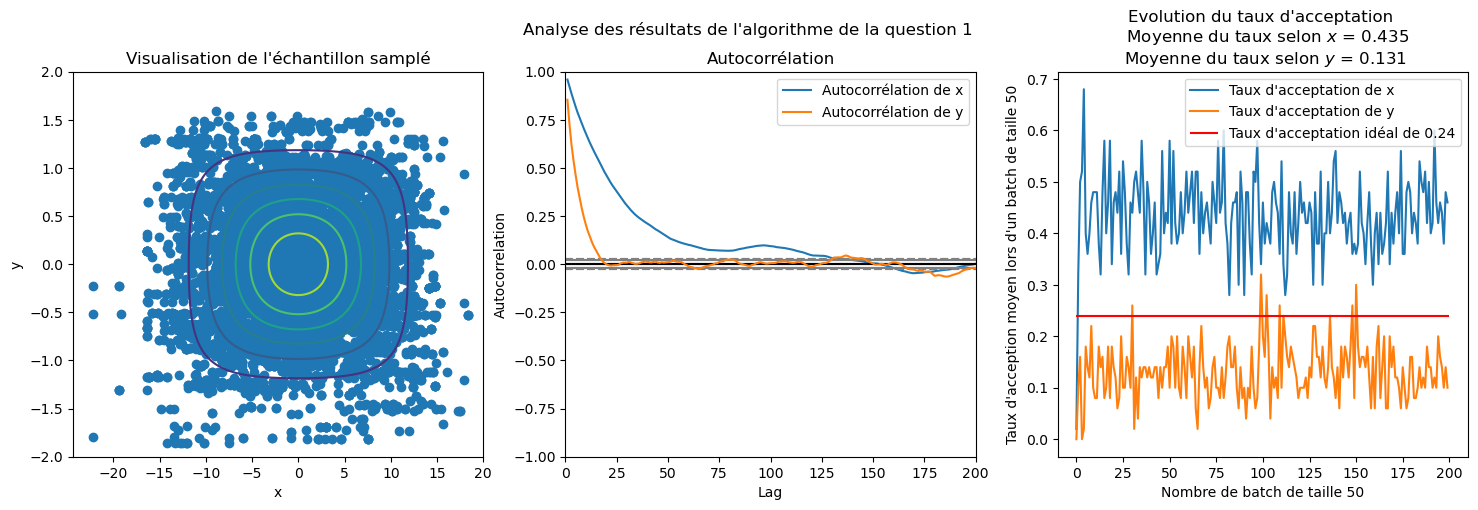

In [4]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
x = np.linspace(-20, 20, 1000)
y = np.linspace(-2, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, a))

plt.contour(X, Y, Z)
plt.scatter(x_sample, y_sample)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Visualisation de l'échantillon samplé")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:], label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(y_sample[1000:], label="Autocorrélation de y")

plt.xlim((0, 200))
plt.title("Autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(list_acc_x, label="Taux d'acceptation de x")
plt.plot(list_acc_y, label="Taux d'acceptation de y")
plt.hlines(0.24,
           0,
           len(list_acc_x),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille 50")
plt.ylabel("Taux d'acception moyen lors d'un batch de taille 50")
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(list_acc_x), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(list_acc_y), 3)))
plt.suptitle("Analyse des résultats de l'algorithme de la question 1")

#### 3.

Pour remédier aux problèmes ci-dessus, je propose deux méthodes : 
- Dans un premier temps, pour avoir une meilleure répartition selon l'axe vertical, on essaye de modifier l'écart-type $\sigma$ de la loi de proposition. En tâtonnant, on essaye de trouver une valeur de $\sigma$ qui améliorerait l'échantillonnage. Il semble qu'en prenant $\sigma = (13,1.5)$, on arrive d'une part à rapprocher de manière significative les taux d'acceptation de la valeur idéale de $0.24$, mais aussi on réduit l'autocorrélation des échantillons. Ces résultats sont donnés ci-dessous.
- Dans un second temps, d'après le constat que l'on sample trop selon $x$ et pas assez selon $y$, on va essayer de changer le noyau $P$ en introduisant un dissymétrie : 
$$P = \alpha P_1 + (1 - \alpha)P_2$$ où $\alpha \in [0,1]$. En faisant varier $\alpha$ on pourra favoriser $P_2$ par rapport à $P_1$. On remarque empiriquement qu'en prenant $\alpha = 0.3$, on améliore déjà l'échantillonnage en ayant des échantillons moins alignés horizontallement entre eux et des taux d'acceptations plus proches de $0.24$. En revanche, cette méthode augmente considérablement l'autocorrélation de la composante selon $x$ de nos échantillons. 

On retiendra ainsi plutôt la première méthode afin d'améliorer l'échantillonnage.

Text(0.5, 0.98, "Analyse des résultats de l'algorithme en prenant $\\sigma$ = [13.   1.5]")

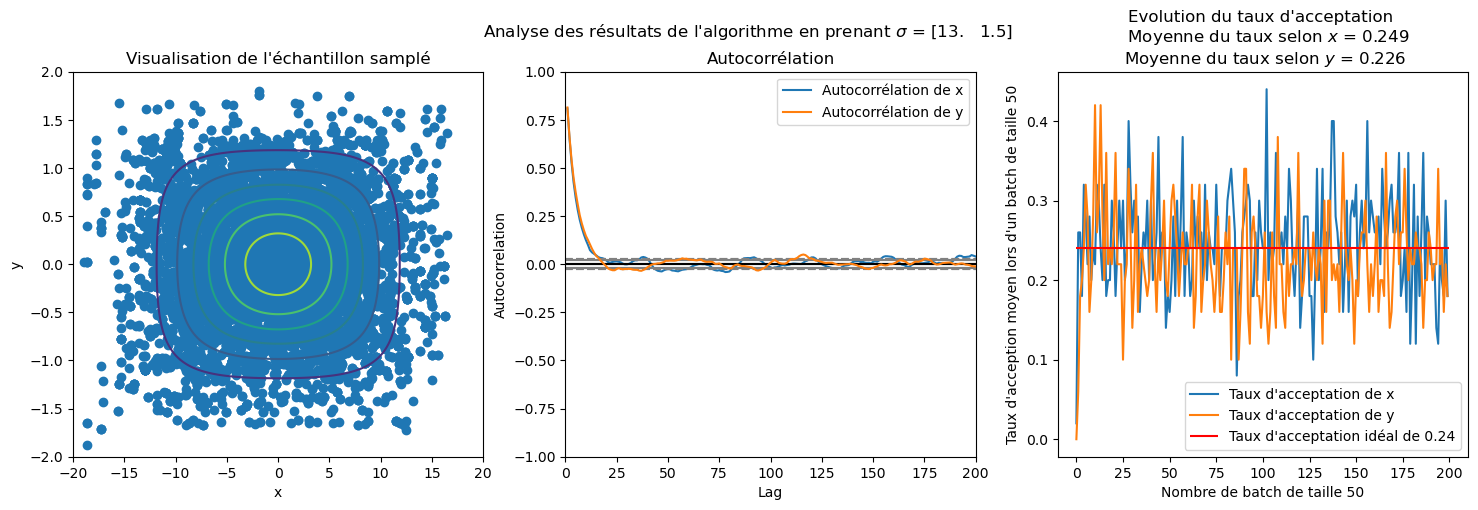

In [5]:
### 1er METHODE ###
### Changer l'ecart-type de la loi de proposition ###

a = 10
sigma = np.array([13, 1.5])

Niter = 10000

x_sample, y_sample, list_acc_x, list_acc_y = sample_pi(0, 0, sigma, a, Niter,
                                                       alpha)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
x = np.linspace(-20, 20, 1000)
y = np.linspace(-2, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, a))

plt.contour(X, Y, Z)
plt.scatter(x_sample, y_sample)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Visualisation de l'échantillon samplé")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:], label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(y_sample[1000:], label="Autocorrélation de y")

plt.xlim((0, 200))
plt.title("Autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(list_acc_x, label="Taux d'acceptation de x")
plt.plot(list_acc_y, label="Taux d'acceptation de y")
plt.hlines(0.24,
           0,
           len(list_acc_x),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille 50")
plt.ylabel("Taux d'acception moyen lors d'un batch de taille 50")
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(list_acc_x), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(list_acc_y), 3)))
### 1er METHODE ###
plt.suptitle("Analyse des résultats de l'algorithme en prenant $\\sigma$ = " +
             str(sigma))

Text(0.5, 0.98, "Analyse des résultats de l'algorithme en prenant $\\alpha$ = 0.5")

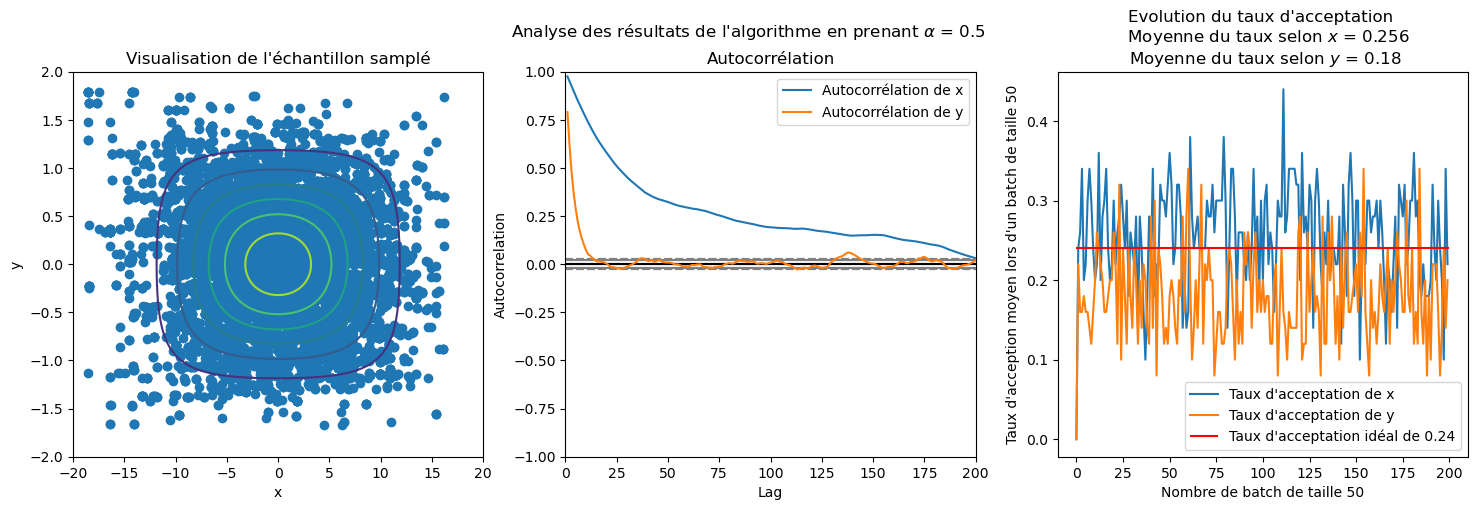

In [6]:
### 2eme METHODE ###
### Changer le noyau P ###
a = 10
sigma = np.array([3, 3])

Niter = 10000

x_sample, y_sample, list_acc_x, list_acc_y = sample_pi(0, 0, sigma, a, Niter,
                                                       0.3)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
x = np.linspace(-20, 20, 1000)
y = np.linspace(-2, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, a))

plt.contour(X, Y, Z)
plt.scatter(x_sample, y_sample)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Visualisation de l'échantillon samplé")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:], label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(y_sample[1000:], label="Autocorrélation de y")

plt.xlim((0, 200))
plt.title("Autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(list_acc_x, label="Taux d'acceptation de x")
plt.plot(list_acc_y, label="Taux d'acceptation de y")
plt.hlines(0.24,
           0,
           len(list_acc_x),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille 50")
plt.ylabel("Taux d'acception moyen lors d'un batch de taille 50")
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(list_acc_x), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(list_acc_y), 3)))
plt.suptitle("Analyse des résultats de l'algorithme en prenant $\\alpha$ = " +
             str(alpha))

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

#### 1.

On commence par implémenter la version adaptative du Metropolis-Hastings within Gibbs sampler. 

In [7]:
def delta(j):
    return min(0.01, 1 / np.sqrt(j))

In [8]:
def adaptative_MHwG(maxIter, x0, y0, a, batch_size, adaptation):
    x_sample = np.zeros(maxIter + 1)
    y_sample = np.zeros(maxIter + 1)
    x_sample[0] = x0
    y_sample[0] = y0

    l1 = 0
    l2 = 0

    nb_x_acc = 0
    nb_y_acc = 0
    acc_x_list = []
    acc_y_list = []

    for j in range(maxIter):
        ## HM sample pour x ##
        x_proposal = stat.norm.rvs(loc=x_sample[j], scale=np.exp(l1))
        log_pi_current_x = log_pi(x_sample[j], y_sample[j], a)
        log_pi_proposal_x = log_pi(x_proposal, y_sample[j], a)
        log_alpha_x = min(0, log_pi_proposal_x - log_pi_current_x)
        U = np.random.random()
        if np.log(U) <= log_alpha_x:
            x_sample[j + 1] = x_proposal
            nb_x_acc += 1
        else:
            x_sample[j + 1] = np.copy(x_sample[j])

        ## HM sample pour y ##
        y_proposal = stat.norm.rvs(loc=y_sample[j], scale=np.exp(l2))
        log_pi_current_y = log_pi(x_sample[j + 1], y_sample[j], a)
        log_pi_proposal_y = log_pi(x_sample[j + 1], y_proposal, a)
        log_alpha_y = min(0, log_pi_proposal_y - log_pi_current_y)
        U = np.random.random()
        if np.log(U) <= log_alpha_y:
            y_sample[j + 1] = y_proposal
            nb_y_acc += 1
        else:
            y_sample[j + 1] = np.copy(y_sample[j])

        ## Adaptative part ##

        if ((j + 1) % batch_size == 0):
            if adaptation:
                if (nb_x_acc / batch_size) > 0.24:
                    l1 += delta(j)
                else:
                    l1 -= delta(j)

                if (nb_y_acc / batch_size) > 0.24:
                    l2 += delta(j)
                else:
                    l2 -= delta(j)

            acc_x_list.append(nb_x_acc / batch_size)
            acc_y_list.append(nb_y_acc / batch_size)

            nb_x_acc = 0
            nb_y_acc = 0

    return x_sample, y_sample, acc_x_list, acc_y_list

On peut alors analyser les performances de cet algorithme et les comparer avec le même algorithme mais sans la partie adaptative.

In [9]:
a = 10
maxIter = 100000
x0 = 0
y0 = 0
batch_size = 50
x_sample, y_sample, acc_x_list, acc_y_list = adaptative_MHwG(
    maxIter, x0, y0, a, batch_size, True)

On commence par visualiser les résultats de l'algorithme de MHwG adaptatif. 
On voit que les échantillons tirés suivent bien la loi $\pi$ voulue et qu'ils ne sont pas trop corrélés entre eux. De plus, en visualisant les taux d'acceptation, on voit bien que, même s'ils ont commencé par être très élévés, ils finissent par converger autour de la valeur idéale de $0.24$, comme ce que l'on veut.

Text(0.5, 0.98, 'Analyse des résultats de Adaptative HMwG')

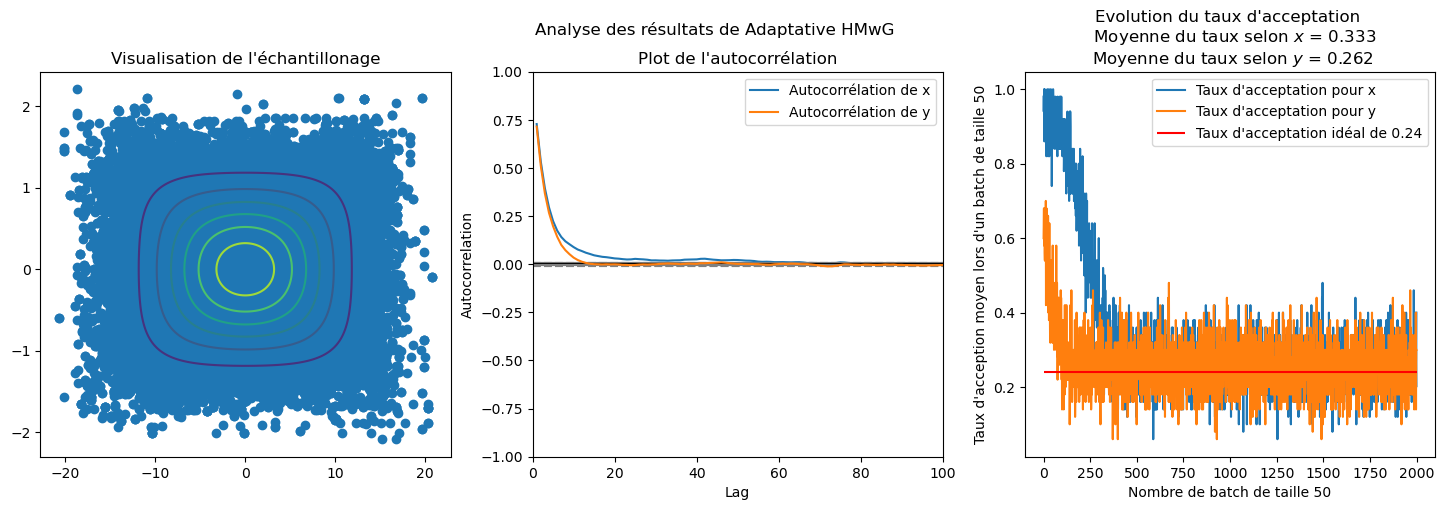

In [10]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
x = np.linspace(-20, 20, 1000)
y = np.linspace(-2, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, a))

plt.contour(X, Y, Z)
plt.scatter(x_sample, y_sample)
plt.title("Visualisation de l'échantillonage")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:], label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(y_sample[1000:], label="Autocorrélation de y")

plt.xlim((0, 100))
plt.title("Plot de l'autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(acc_x_list, label="Taux d'acceptation pour x")
plt.plot(acc_y_list, label="Taux d'acceptation pour y")
plt.hlines(0.24,
           0,
           len(acc_x_list),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille 50")
plt.ylabel("Taux d'acception moyen lors d'un batch de taille 50")
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(acc_x_list), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(acc_y_list), 3)))

plt.suptitle("Analyse des résultats de Adaptative HMwG")

On regarde ensuite les résultat du même algorithme mais sans la partie adaptative. 
On voit alors que les échantillons sont très corrélés entre eux, surtoût leur composante selon $x$. De plus, les taux d'acceptation ne sont pas du tout autour de la valeur idéale de $0.24$.

On peut également noter que contairement à la partie 1, quand on utilise l'algorithme adaptatif, on a pas besoin d'avoir un a priori sur l'écart-type à utiliser pour notre loi de proposition. En effet, l'algorithme va lui même fait évoluer cet écart-type pour trouver celui qui convient le mieux. 

Tous ces résultats et raisons nous poussent à dire que l'algorithme adaptatif est meilleur que l'algorithme MHwG de base et il vaut donc mieux l'utiliser en pratique.

Text(0.5, 0.98, "Analyse des résultats de HMwG sans l'adaptation")

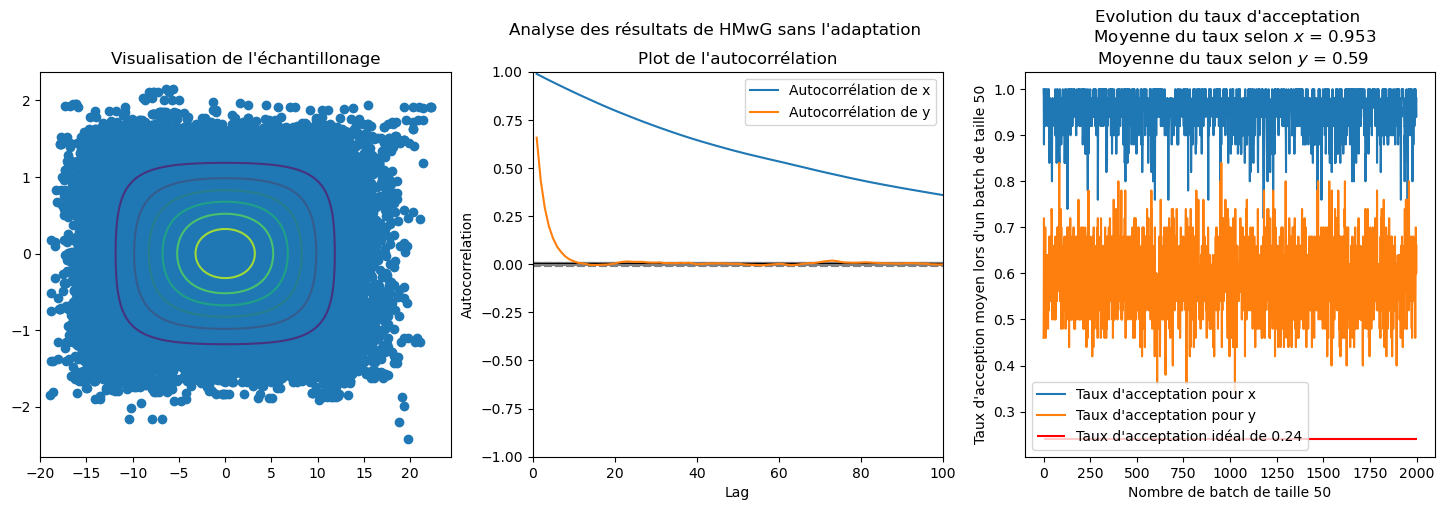

In [11]:
x_sample, y_sample, acc_x_list, acc_y_list = adaptative_MHwG(
    maxIter, x0, y0, a, batch_size, False)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
x = np.linspace(-20, 20, 1000)
y = np.linspace(-2, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, a))

plt.contour(X, Y, Z)
plt.scatter(x_sample, y_sample)
plt.title("Visualisation de l'échantillonage")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:], label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(y_sample[1000:], label="Autocorrélation de y")

plt.xlim((0, 100))
plt.title("Plot de l'autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(acc_x_list, label="Taux d'acceptation pour x")
plt.plot(acc_y_list, label="Taux d'acceptation pour y")
plt.hlines(0.24,
           0,
           len(acc_x_list),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille 50")
plt.ylabel("Taux d'acception moyen lors d'un batch de taille 50")
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(acc_x_list), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(acc_y_list), 3)))

plt.suptitle("Analyse des résultats de HMwG sans l\'adaptation")

#### 2.

On compare ensuite l'utilité de la partie adaptative de l'algorithme HMwG sur une densité plus compliquée, ici une "banana-shaped density". 

In [12]:
def log_f_B(x, B):
    return (-(x[0]**2) / 200 - ((x[1] - B * x[0]**2 + 100 * B)**2) / 2 -
            (np.sum(x[2:]**2)) / 2)

On commence par sampler un échantillon de notre loi cible de manière "exacte" afin de voir à quoi cette densité ressemble et à quoi on doit s'attendre pour la suite. Cet échantillon vit dans $\mathbb{R}^{20}$, car on choisit $d = 20$, mais pour plus de lisibilité, on n'affiche que les 2 premières coordonnées.  

In [13]:
d = 20
B = 0.1
Sigma = np.loadtxt('tmalaexcov.txt')

X = stat.multivariate_normal.rvs(mean=np.zeros(d), cov=Sigma**2, size=5000)
X[:, 1] = X[:, 1] + B * (X[:, 0]**2 - X[0, 0]**2)

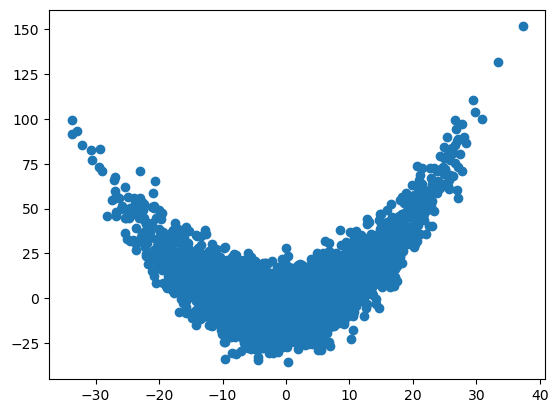

In [14]:
plt.scatter(X[:, 0], X[:, 1])

On implémente ensuite l'algorithme de Metropolis-Hastings within Gibbs sampler adaptatif pour notre loi cible.

In [15]:
def adaptative_MHwG_banana(maxIter, X0, d, B, batch_size, adaptation):
    x_sample = np.zeros((maxIter + 1, d))
    x_sample[0] = X0

    l = np.zeros(d)

    nb_x_acc = np.zeros(d)

    list_nb_acc_x = []
    list_nb_acc_y = []

    for k in range(maxIter):

        for i in range(d):
            if i == 0:
                x_i_current = np.copy(x_sample[k])
            else:
                x_i_current = np.concatenate(
                    (np.copy(x_sample[k + 1, :i]), np.copy(x_sample[k, i:])))
            #print(x_i_current.shape)
            x_i_proposal = np.copy(x_i_current)
            x_i_proposal[i] = stat.norm.rvs(loc=x_sample[k, i],
                                            scale=np.exp(l[i]))
            log_pi_current_x_k = log_f_B(x_i_current, B)
            log_pi_proposal_x_k = log_f_B(x_i_proposal, B)
            log_alpha_x = min(0, log_pi_proposal_x_k - log_pi_current_x_k)
            U = np.random.random()
            if np.log(U) <= log_alpha_x:
                x_sample[k + 1] = x_i_proposal
                nb_x_acc[i] += 1
            else:
                x_sample[k + 1] = np.copy(x_i_current)

        ## Adaptative part ##

        if ((k + 1) % batch_size == 0):
            if adaptation:
                for i in range(d):
                    if (nb_x_acc[i] / batch_size) > 0.24:
                        l[i] += delta(k)
                    else:
                        l[i] -= delta(k)

            list_nb_acc_x.append(nb_x_acc[0] / batch_size)
            list_nb_acc_y.append(nb_x_acc[1] / batch_size)

            nb_x_acc = np.zeros(d)

    return x_sample, list_nb_acc_x, list_nb_acc_y

On peut alors tester notre algorithme et le comparer à sa version non-adaptative.

On remarque plusieurs choses : 
- L'échantillon donné par l'algorthime adaptatif ressemble bien à la densité voulue, c'est à dire qu'il ressemble bien à une banane. Cependant, on remarque que les valeurs numériques ne correspondent pas : les ordonnées des échantillons varient entre -15 et 40 là où la vrai densité se répartie entre -30 et 100. 
- Parfois, on remarque aussi que une des "branches" de la banane est plus explorée que l'autre, menant à une banane asymétrique. 
- Le plot de l'autocorrélation est très mauvais, même dans la version adaptatif. Les échantillons semblent donc être très corrélés entre eux, ce que cet algorithme voulait justement éviter. 
- Pour ce qui est des taux d'acceptation, ils semblent se diriger vers la valeur souhaitée de $0.24$ comme souhaité. Cependant, on remarque que le taux d'acceptation selon la première coordonnée fait parfois des sauts et redevient très grand. Je ne sais pas trop expliquer pourquoi. En revanche, celui selon la deuxième coordonnée n'a pas de genre de comportement. 

In [16]:
maxIter = 20000
#X0 = np.random.random(d)
X0 = np.zeros(d)
adaptation = True
batch_size = 50
x_sample, list_nb_acc_x, list_nb_acc_y = adaptative_MHwG_banana(
    maxIter, X0, d, B, batch_size, adaptation)

Text(0.5, 0.98, 'Analyse des résultats de Adaptative HMwG')

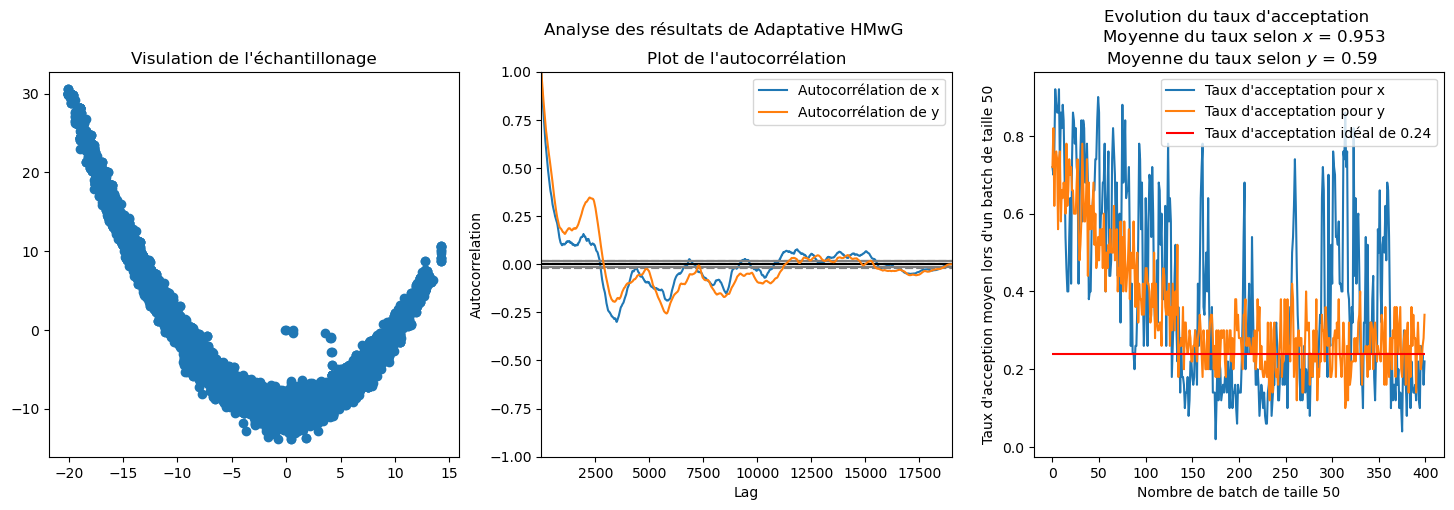

In [17]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(x_sample[:, 0], x_sample[:, 1])
plt.title("Visulation de l'échantillonage")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:, 0],
                                 label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(x_sample[1000:, 1],
                                 label="Autocorrélation de y")

#plt.xlim((0,100))
plt.title("Plot de l'autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(list_nb_acc_x, label="Taux d'acceptation pour x")
plt.plot(list_nb_acc_y, label="Taux d'acceptation pour y")
plt.hlines(0.24,
           0,
           len(list_nb_acc_y),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille " + str(batch_size))
plt.ylabel("Taux d'acception moyen lors d'un batch de taille " +
           str(batch_size))
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(acc_x_list), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(acc_y_list), 3)))

plt.suptitle("Analyse des résultats de Adaptative HMwG")

On peut comparer les résultats ci-dessus avec ceux obtenus à partir de l'échantillonneur de MHwG sans la partie adaptative : 
- La densité obtenue ressemble bien à une banane, mais toujours avec le même problème de valeur que ci-dessus.
- Les échantillons sont très corrélés entre eux, mais c'est cohérent car nous n'avons rien fait ici pour empêcher cela.
- Les taux d'acceptation sont très loin de la valeur optimale.


En conclusion, dans ce cas d'une densité plus complexe, il est moins clair que la partie adaptative de l'algorithme apporte effectivement quelque chose, puisque les résultats avec ou sans se ressemblent beaucoup.

Text(0.5, 0.98, 'Analyse des résultats HMwG sans la partie adaptative')

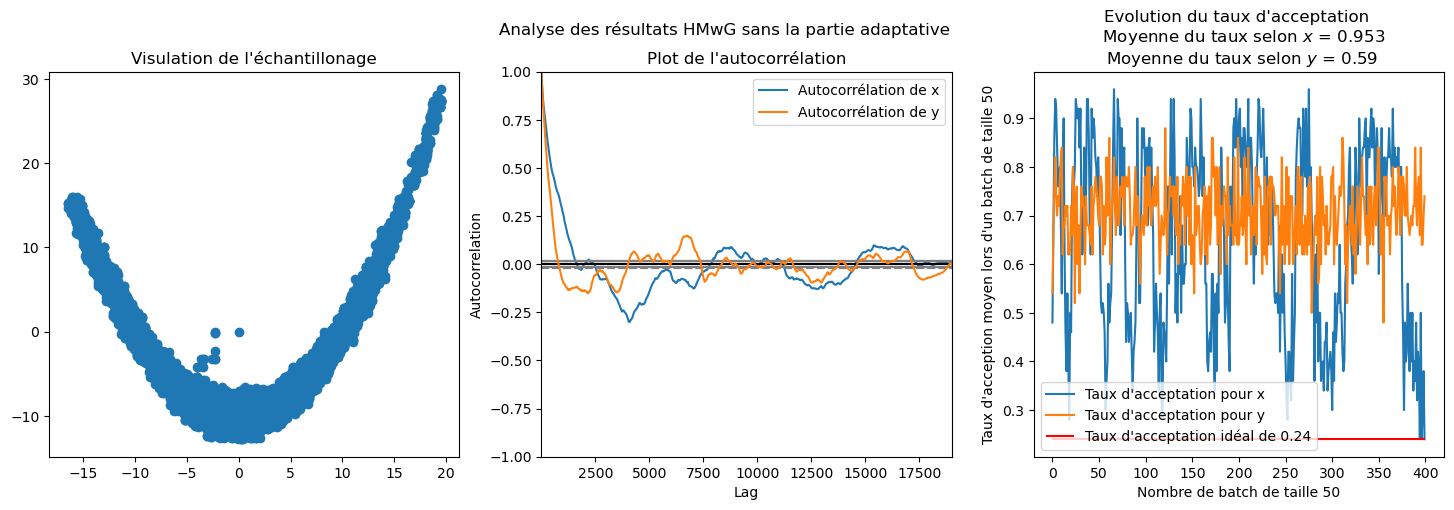

In [18]:
x_sample, list_nb_acc_x, list_nb_acc_y = adaptative_MHwG_banana(
    maxIter, X0, d, B, batch_size, False)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(x_sample[:, 0], x_sample[:, 1])
plt.title("Visulation de l'échantillonage")

plt.subplot(1, 3, 2)
pd.plotting.autocorrelation_plot(x_sample[1000:, 0],
                                 label="Autocorrélation de x")
pd.plotting.autocorrelation_plot(x_sample[1000:, 1],
                                 label="Autocorrélation de y")

#plt.xlim((0,100))
plt.title("Plot de l'autocorrélation")

plt.subplot(1, 3, 3)
plt.plot(list_nb_acc_x, label="Taux d'acceptation pour x")
plt.plot(list_nb_acc_y, label="Taux d'acceptation pour y")
plt.hlines(0.24,
           0,
           len(list_nb_acc_y),
           colors='red',
           label="Taux d'acceptation idéal de 0.24")
plt.xlabel("Nombre de batch de taille " + str(batch_size))
plt.ylabel("Taux d'acception moyen lors d'un batch de taille " +
           str(batch_size))
plt.legend()
plt.title("Evolution du taux d'acceptation \n  Moyenne du taux selon $x$ = " +
          str(round(np.mean(acc_x_list), 3)) +
          "\n Moyenne du taux selon $y$ = " +
          str(round(np.mean(acc_y_list), 3)))

plt.suptitle("Analyse des résultats HMwG sans la partie adaptative")

## Exercice 2 : Sampling from multimodal distributions

### 2.A – A toy example

On commence par essayer de visualiser la densité cible $\pi$, que ce soit en 2D ou en 3D. 

In [19]:
def multivariate_gaussien(x, mu, sigma, w):
    N = len(mu)
    pi_x = 0
    for i in range(N):
        pi_x += (w / (2 * np.pi * sigma**2)) * np.exp(-np.dot(
            (x - mu[i]), np.transpose(x - mu[i])) / (2 * sigma**2))
    return pi_x

In [20]:
mu = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68],
               [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60],
               [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88],
               [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.50],
               [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])
sigma = 0.1
w = 0.05

In [21]:
Nb_points = 200
x = np.linspace(0, 10, Nb_points)
y = np.linspace(0, 10, Nb_points)
X, Y = np.meshgrid(x, y)

Z = np.zeros((Nb_points, Nb_points))
for i in range(Nb_points):
    for j in range(Nb_points):
        Z[i, j] = multivariate_gaussien([X[i, j], Y[i, j]], mu, sigma, w)

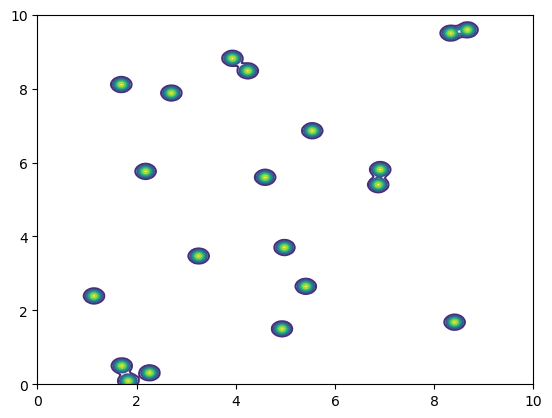

In [22]:
plt.contour(X, Y, Z)

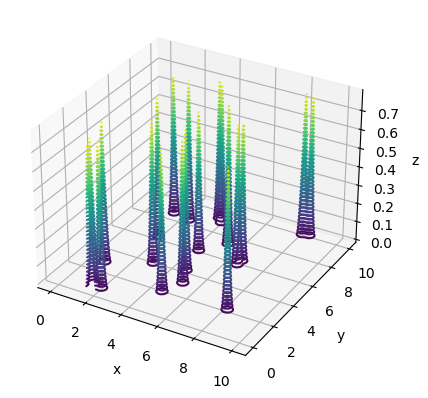

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#### 1.

On implémente ensuite l'algorithme de Metropolis-Hastings Symmetric Random Walk afin d'échantillonner notre loi cible. 

In [24]:
def SRWHM(x0, y0, maxIter, mu, sigma, w, sigma_prop):
    z_sample = np.zeros((maxIter + 1, 2))
    z_sample[0] = [x0, y0]

    for i in range(maxIter):
        #Proposal
        z_proposal = stat.multivariate_normal.rvs(mean=z_sample[i],
                                                  cov=sigma_prop)

        #Acceptance-Rejection
        U = np.random.random()
        alpha = min(
            1,
            multivariate_gaussien(z_proposal, mu, sigma, w) /
            multivariate_gaussien(z_sample[i], mu, sigma, w))
        if U <= alpha:
            z_sample[i + 1] = z_proposal
        else:
            z_sample[i + 1] = np.copy(z_sample[i])

    return z_sample

On peut alors le tester et étudier l'échantillon obtenu.

In [25]:
maxIter = 10000
x0 = np.random.random()
y0 = np.random.random()
sigma_prop = 1

z = SRWHM(x0, y0, maxIter, mu, sigma, w, sigma_prop)

On remarque que l'échantillonnage de notre loi cible est loin d'être convainquant avec cet algorithme. En effet, toutes les gaussiennes ne sont pas visitées, certaines ne sont visitées qu'un nombre très faible de fois et surtout, les échantillons sont extrêmement corrélés entre eux, comme le montre le plot d'autocorrélation.

Text(0.5, 1.0, 'Autocorrélation des échantillons tirés')

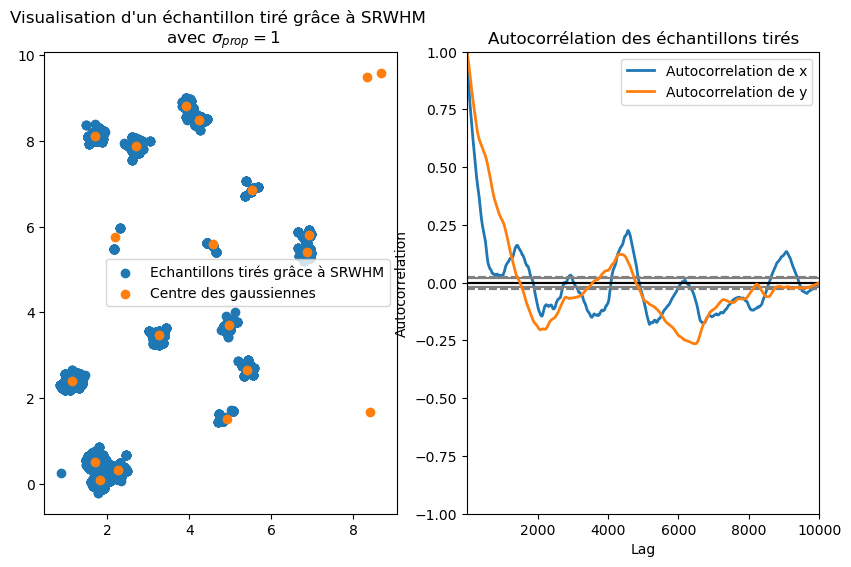

In [26]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(z[:, 0], z[:, 1], label="Echantillons tirés grâce à SRWHM")
plt.scatter(mu[:, 0], mu[:, 1], label="Centre des gaussiennes")
plt.legend()
plt.title(
    "Visualisation d'un échantillon tiré grâce à SRWHM \n avec $\\sigma_{prop} = $"
    + str(sigma_prop))

plt.subplot(1, 2, 2)
pd.plotting.autocorrelation_plot(z[:, 0],
                                 label='Autocorrelation de x',
                                 linewidth=2)
pd.plotting.autocorrelation_plot(z[:, 1],
                                 label='Autocorrelation de y',
                                 linewidth=2)

# Limits the lags in the plot
#plt.xlim((0,100))
plt.title("Autocorrélation des échantillons tirés")

On peut se dire que faire varier l'écart-type de la loi de proposation $\sigma_{prop}$ pourrait changer les choses et peut-être les améliorer. C'est ce que j'essaye de voir ci-dessous. 

On voit effectivement que plus $\sigma_{prop}$ est grand, plus on visite des gaussiennes. Cependant, il arrive quand même que certaines gaussiennes ne soient pas visitées, ou seulement un nombre très faible de fois. 
De plus, on remarque que les plot d'autocorrélation sont toujours très mauvais, les échantillons ne sont pas indépendants les uns des autres. 

Il faut donc trouver une autre manière d'echantillonner cette loi.

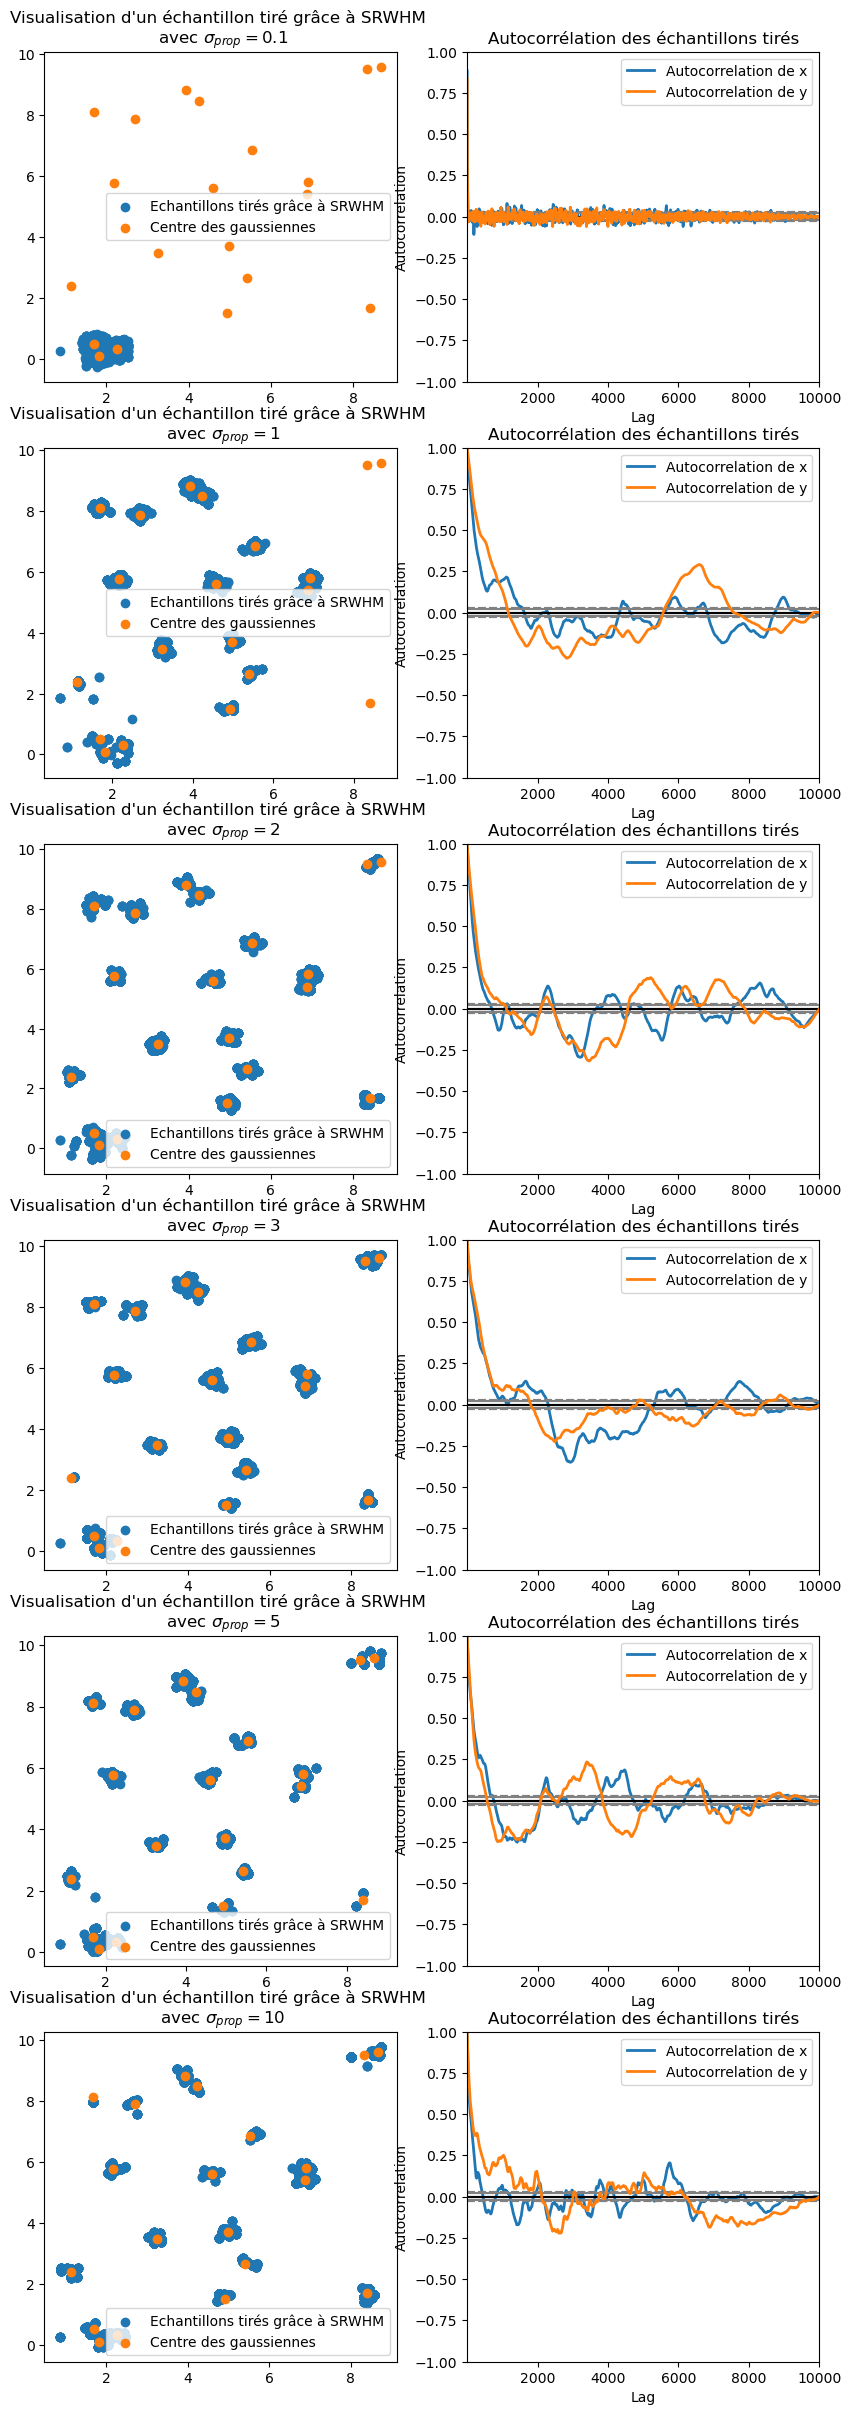

In [27]:
plt.figure(figsize=(10, 30))
sigma_prop_list = [0.1, 1, 2, 3, 5, 10]
for i in range(len(sigma_prop_list)):
    z = SRWHM(x0, y0, maxIter, mu, sigma, w, sigma_prop_list[i])
    plt.subplot(6, 2, 2 * i + 1)
    plt.scatter(z[:, 0], z[:, 1], label="Echantillons tirés grâce à SRWHM")
    plt.scatter(mu[:, 0], mu[:, 1], label="Centre des gaussiennes")
    plt.legend()
    plt.title(
        "Visualisation d'un échantillon tiré grâce à SRWHM \n avec $\\sigma_{prop} = $"
        + str(sigma_prop_list[i]))
    plt.subplot(6, 2, 2 * i + 2)
    pd.plotting.autocorrelation_plot(z[:, 0],
                                     label='Autocorrelation de x',
                                     linewidth=2)
    pd.plotting.autocorrelation_plot(z[:, 1],
                                     label='Autocorrelation de y',
                                     linewidth=2)

    # Limits the lags in the plot
    #plt.xlim((0,100))
    plt.title("Autocorrélation des échantillons tirés")

#### 2.

On implémente ensuite l'algorithme de MHwG adaptatif de l'exercice précédent. Ici, on a pas à choisir d'écart-type pour notre loi de proposition, on peut donc espérer que cet algorithme fonctionne mieux. 

In [28]:
def adaptative_MHwG_gaussian(maxIter, x0, y0, mu, sigma, w, batch_size):
    x_sample = np.zeros(maxIter + 1)
    y_sample = np.zeros(maxIter + 1)
    x_sample[0] = x0
    y_sample[0] = y0

    l1 = 0
    l2 = 0

    nb_x_acc = 0
    nb_y_acc = 0
    acc_x_list = []
    acc_y_list = []

    for j in range(maxIter):
        ## HM sample pour x ##
        x_proposal = stat.norm.rvs(loc=x_sample[j], scale=np.exp(l1))
        pi_current_x = multivariate_gaussien([x_sample[j], y_sample[j]], mu,
                                             sigma, w)
        pi_proposal_x = multivariate_gaussien([x_proposal, y_sample[j]], mu,
                                              sigma, w)
        alpha_x = min(1, pi_proposal_x / pi_current_x)
        U = np.random.random()
        if U <= alpha_x:
            x_sample[j + 1] = x_proposal
            nb_x_acc += 1
        else:
            x_sample[j + 1] = np.copy(x_sample[j])

        ## HM sample pour y ##
        y_proposal = stat.norm.rvs(loc=y_sample[j], scale=np.exp(l2))
        pi_current_y = multivariate_gaussien([x_sample[j + 1], y_sample[j]],
                                             mu, sigma, w)
        pi_proposal_y = multivariate_gaussien([x_sample[j + 1], y_proposal],
                                              mu, sigma, w)
        alpha_y = min(1, pi_proposal_y / pi_current_y)
        U = np.random.random()
        if U <= alpha_y:
            y_sample[j + 1] = y_proposal
            nb_y_acc += 1
        else:
            y_sample[j + 1] = np.copy(y_sample[j])

        ## Adaptative part ##

        if ((j + 1) % batch_size == 0):
            if adaptation:
                if (nb_x_acc / batch_size) > 0.24:
                    l1 += delta(j)
                else:
                    l1 -= delta(j)

                if (nb_y_acc / batch_size) > 0.24:
                    l2 += delta(j)
                else:
                    l2 -= delta(j)

            acc_x_list.append(nb_x_acc / batch_size)
            acc_y_list.append(nb_y_acc / batch_size)

            nb_x_acc = 0
            nb_y_acc = 0

    return x_sample, y_sample, acc_x_list, acc_y_list

In [29]:
maxIter = 10000
x0 = np.random.random()
y0 = np.random.random()

x_sample, y_sample, acc_x_list, acc_y_list = adaptative_MHwG_gaussian(
    maxIter, x0, y0, mu, sigma, w, batch_size)

En le testant on se rend compte que notre échantillon visite très très peu de gaussiennes (pafois une seule), ce qui ne convient pas du tout. En revanche, on peut noter que les échantillons sont très peu corrélés entre eux. 

On en déduit que cet algorithme ne fonctionne pas en pratique pour ce genre de densités, il faut donc en essayer un autre.

(0.0, 100.0)

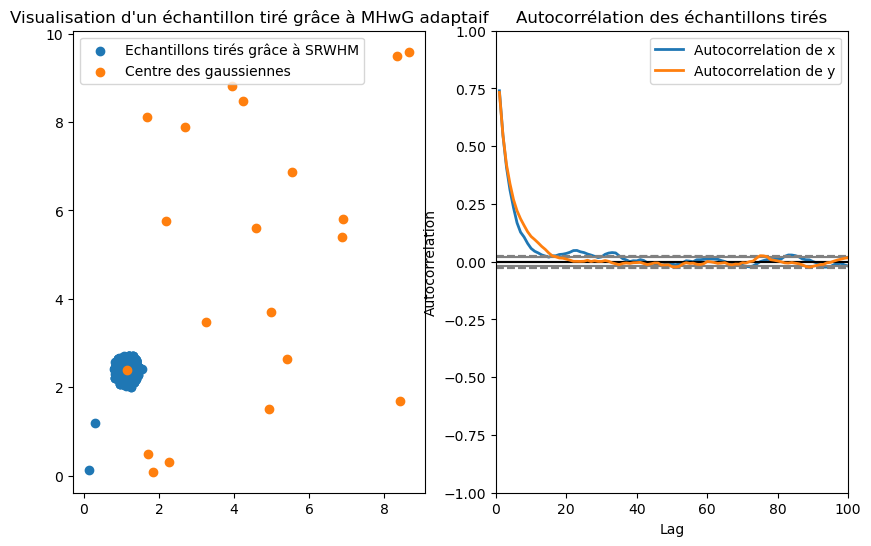

In [30]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_sample, y_sample, label="Echantillons tirés grâce à SRWHM")
plt.scatter(mu[:, 0], mu[:, 1], label="Centre des gaussiennes")
plt.legend()
plt.title("Visualisation d'un échantillon tiré grâce à MHwG adaptaif")

plt.subplot(1, 2, 2)
pd.plotting.autocorrelation_plot(x_sample,
                                 label='Autocorrelation de x',
                                 linewidth=2)
pd.plotting.autocorrelation_plot(y_sample,
                                 label='Autocorrelation de y',
                                 linewidth=2)

# Limits the lags in the plot
plt.title("Autocorrélation des échantillons tirés")
plt.xlim(0, 100)

### 2.B – Parallel Tempering

#### 1. 
On implémente alors l'algorithme de Parallel Tempering afin d'échantillonner notre loi cible $\pi$. 

In [31]:
def Parallel_Tempering(K, T, maxIter, mu, sigma, w):
    z = np.zeros((K, maxIter + 1, 2))

    for n in range(maxIter):
        for i in range(K):
            ##Draw Y^(i)_{n+1} using the transition kernel P(i)(X^(i)_n,.)
            y_proposal = stat.multivariate_normal.rvs(mean=z[i, n],
                                                      cov=0.25 * np.sqrt(T[i]))

            log_alpha = min(
                0,
                np.log(multivariate_gaussien(y_proposal, mu, sigma, w)) / T[i]
                - np.log(multivariate_gaussien(z[i, n], mu, sigma, w)) / T[i])
            U = np.random.random()
            if np.log(U) <= log_alpha:
                z[i, n + 1] = y_proposal
            else:
                z[i, n + 1] = np.copy(z[i, n])

        # Choose uniformly i and j such that |i-j| = 1
        i = np.random.choice(range(K))
        if i == 0:
            j = i + 1
        elif i == K - 1:
            j = i - 1
        else:
            j = np.random.choice([i - 1, i + 1])

        #Compute the swap acceptance probability alpha(i, j)
        num = np.log(multivariate_gaussien(
            z[j, n + 1], mu, sigma, w)) / T[i] + np.log(
                multivariate_gaussien(z[i, n + 1], mu, sigma, w)) / T[j]
        denom = np.log(multivariate_gaussien(
            z[i, n + 1], mu, sigma, w)) / T[i] + np.log(
                multivariate_gaussien(z[j, n + 1], mu, sigma, w)) / T[j]
        log_alpha = min(0, num - denom)
        U = np.random.random()
        if np.log(U) <= log_alpha:
            #Swap#
            aux = z[i, n + 1]
            z[i, n + 1] = np.copy(z[j, n + 1])
            z[j, n + 1] = np.copy(aux)
    return z

#### 2. 
On le teste alors avec les temperatures données dans l'énoncé.

L'échantillon qui nous interesse en particulier est celui pour $T = 1$. On voit qu'il visite toutes les gaussiennes, et reste suffisament longtemps dans chacune d'elles. On peut donc se convaincre que la loi $\pi$ est bien échantillonée grâce à cet algorithme. En tout cas, elle est mieux échantillonner avec cet algorithme qu'avec ceux proposés ci-dessus. 
En revanche, on peut noter que les plot d'autocorrélation ne sont pas parfaits, les échantillons restent relativement corrélés entre eux, ce que l'on ne veut pas.

In [32]:
K = 5
T = np.array([60, 21.6, 7.7, 2.8, 1])
maxIter = 10000
z = Parallel_Tempering(K, T, maxIter, mu, sigma, w)

/var/folders/_d/xgqzpq6x1dn227pxd6dvmhsc0000gn/T/ipykernel_22334/745390759.py:9: RuntimeWarning: divide by zero encountered in log
  log_alpha = min(0,np.log(multivariate_gaussien(y_proposal,mu,sigma,w))/T[i]- np.log(multivariate_gaussien(z[i,n],mu,sigma,w))/T[i])


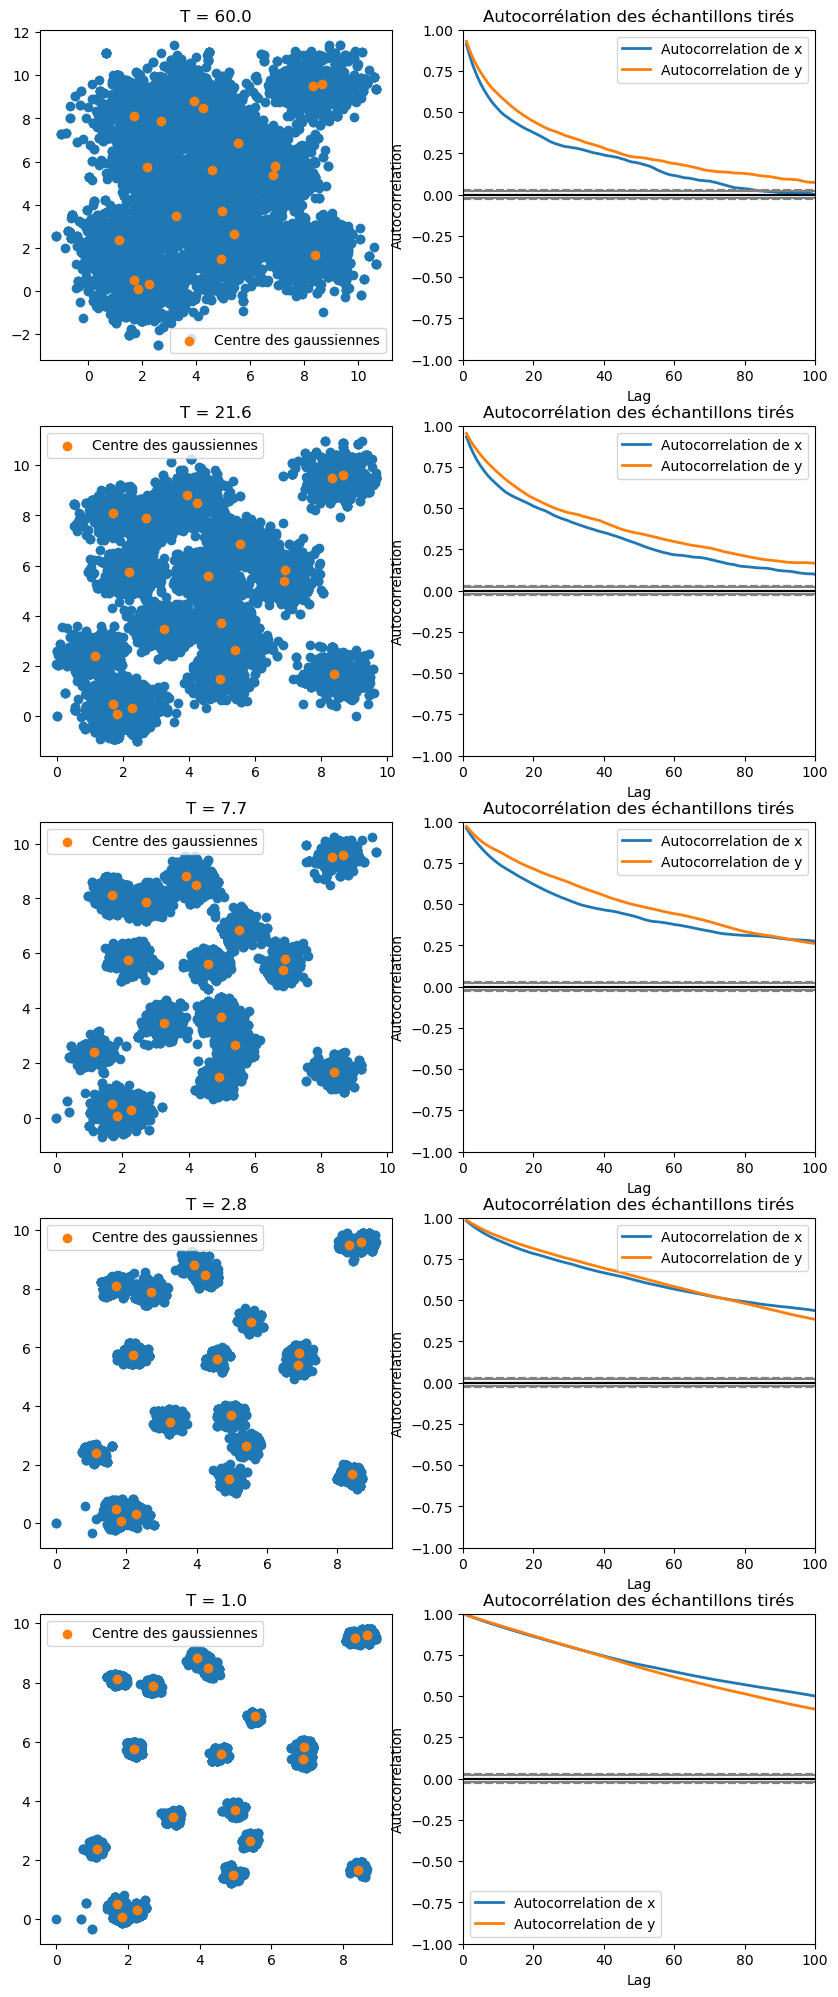

In [33]:
plt.figure(figsize=(10, 30))
for i in range(K):
    plt.subplot(6, 2, 2 * i + 1)
    plt.scatter(z[i, :, 0], z[i, :, 1])
    plt.scatter(mu[:, 0], mu[:, 1], label="Centre des gaussiennes")
    plt.legend()
    plt.title("T = " + str(T[i]))

    plt.subplot(6, 2, 2 * i + 2)
    pd.plotting.autocorrelation_plot(z[i, :, 0],
                                     label='Autocorrelation de x',
                                     linewidth=2)
    pd.plotting.autocorrelation_plot(z[i, :, 1],
                                     label='Autocorrelation de y',
                                     linewidth=2)

    # Limits the lags in the plot
    plt.xlim((0, 100))
    plt.title("Autocorrélation des échantillons tirés")

## Exercice 3 : Bayesian analysis of a one-way random effects model

#### 2.

On commence par implémenter un échantillonneur de Gibbs qui met à jour $\sigma^2$ puis $\tau^2$ puis $\mu$ et enfin $X$ les uns après les autres.

In [34]:
def gibbs(sigma2_init, tau2_init, mu_init, X_init, N, k_i, alpha, beta, gamma,
          y):
    ## sigma^2 ##
    sigma2 = stat.invgamma.rvs(a=alpha + N / 2,
                               scale=0.5 * np.sum(
                                   (X_init - mu_init)**2) + beta)

    ## tau^2 ##
    tau2 = stat.invgamma.rvs(a=gamma + (N * k_i) / 2,
                             scale=0.5 * np.sum((X_init - y.T)**2) + beta)

    ## mu ##
    mu = stat.norm.rvs(loc=np.sum(X_init) / N, scale=np.sqrt(sigma2 / N))

    ## X ##
    X = np.zeros(N)
    for i in range(N):
        m = (tau2 * mu + sigma2 * np.sum(y[i, :])) / (k_i * sigma2 + tau2)
        s = np.sqrt((sigma2 * tau2) / (k_i * sigma2 + tau2))
        X[i] = stat.norm.rvs(loc=m, scale=s)

    return sigma2, tau2, mu, X

#### 3.
On implémente également un échantilloneur de Gibbs par blocs qui met à jour $\sigma^2$ puis $\tau^2$ et le bloc $(X,\mu)$ d'un coup.

In [35]:
def block_gibbs(sigma2_init, tau2_init, mu_init, X_init, N, k_i, alpha, beta,
                gamma, y):
    ## sigma^2 ##
    sigma2 = stat.invgamma.rvs(a=alpha + N / 2,
                               scale=0.5 * np.sum(
                                   (X_init - mu_init)**2) + beta)

    ## tau^2 ##
    tau2 = stat.invgamma.rvs(a=gamma + N * k_i / 2,
                             scale=0.5 * np.sum((X_init - y.T)**2) + beta)

    ## (X,mu) ##
    inv_sigma = np.diag([(tau2 + k_i * sigma2) / (tau2 * sigma2)] * (N + 1))
    inv_sigma[N, N] = N / sigma2
    inv_sigma[:, N] = -1 / sigma2
    inv_sigma[N, :] = -1 / sigma2
    #print(np.linalg.det(inv_sigma))
    theta = np.sum(Y, 1) / k_i
    theta = np.concatenate((theta, [np.sum(Y) / (N * k_i)]))

    tirage = stat.multivariate_normal.rvs(mean=theta,
                                          cov=np.linalg.pinv(inv_sigma))
    X = tirage[:N]
    mu = tirage[N]

    return sigma2, tau2, mu, X

#### 5.

On génère alors des données à partir du modèle de l'énoncé afin de tester les deux échantilloneurs. 

In [36]:
N = 100
k_i = 100
alpha = 0.1
beta = 0.1
gamma = 0.1

## Les vrais paramètres qu'on cherche à estimer ##
sigma2_vrai = 0.1
tau2_vrai = 0.2
mu_vrai = 3

epsilon = stat.norm.rvs(size=(N, k_i), loc=0, scale=np.sqrt(tau2_vrai))
X_vrai = stat.norm.rvs(size=N, loc=mu_vrai, scale=np.sqrt(sigma2_vrai))
Y = X_vrai.reshape(-1, 1) + epsilon

#### Pour l'échantillonneur de Gibbs

In [37]:
maxIter = 10000
sigma2 = np.zeros(maxIter + 1)
tau2 = np.zeros(maxIter + 1)
mu = np.zeros(maxIter + 1)
X = np.zeros((maxIter + 1, N))

sigma2[0] = np.random.random()
tau2[0] = np.random.random()
mu[0] = np.random.random()
X[0] = np.random.random(size=N)
for i in range(maxIter):
    sigma2[i + 1], tau2[i + 1], mu[i + 1], X[i + 1] = gibbs(
        sigma2[i], tau2[i], mu[i], X[i], N, k_i, alpha, beta, gamma, Y)

Text(0.5, 1.0, 'Comparaison des densités échantillonnée et de la vraie densité')

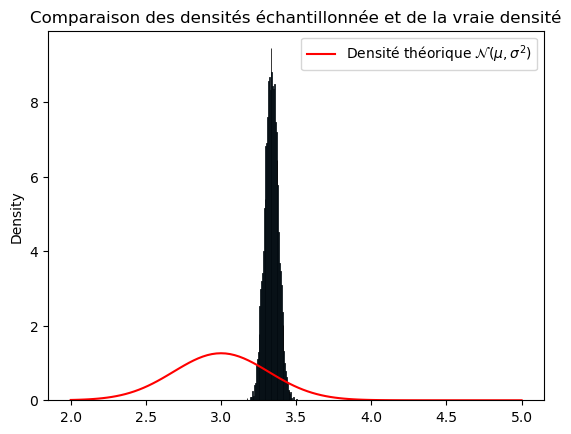

In [38]:
sns.histplot(X[1000:, 0], stat="density")
x = np.linspace(2, 5, 100)
plt.plot(x,
         stat.norm.pdf(x, loc=mu_vrai, scale=np.sqrt(sigma2_vrai)),
         label="Densité théorique $\\mathcal{N}(\\mu,\\sigma^2)$",
         c='red')
plt.legend()
plt.title("Comparaison des densités échantillonnée et de la vraie densité")

On commence par constater que les échantillons de $X$ tirés grâce à l'algorithme de Gibbs ne sont pas excellent mais on peut quand même reconnaître une gaussienne. En effet, ils sont relativment bien centrés en $\mu$. En revanche la variance des échantillons est sous-estimée mais on est globalement satisfait de ce tirage.

Text(0.5, 0.98, "Histogramme des échantillons tirés grâce à l'algorithme de Gibbs")

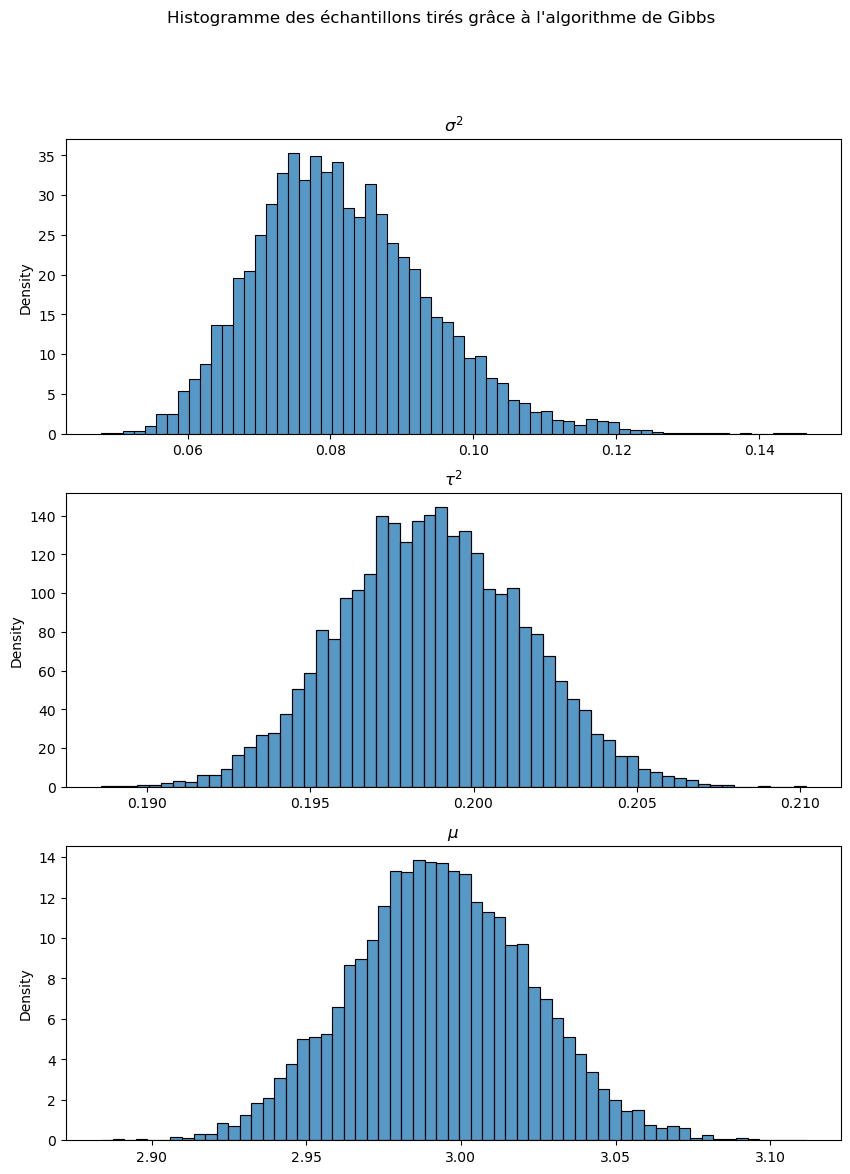

In [39]:
plt.figure(figsize=(10, 13))
plt.subplot(3, 1, 1)
sns.histplot(sigma2[1000:], stat="density")
plt.title("$\\sigma^2$")

plt.subplot(3, 1, 2)
sns.histplot(tau2[1000:], stat="density")
plt.title("$\\tau^2$")

plt.subplot(3, 1, 3)
sns.histplot(mu[1000:], stat="density")
plt.title("$\\mu$")

plt.suptitle(
    "Histogramme des échantillons tirés grâce à l'algorithme de Gibbs")

In [40]:
print("Moyenne des sigma2 simulés : " + str(round(np.mean(sigma2[1000:]), 3)))
print("Vrai sigma2 : " + str(sigma2_vrai))
print("Différence entre les deux : " +
      str(np.abs(np.mean(sigma2[1000:]) - sigma2_vrai)))
print("\n")
print("Moyenne des tau2 simulés : " + str(round(np.mean(tau2[1000:]), 3)))
print("Vrai tau2 : " + str(tau2_vrai))
print("Différence entre les deux : " +
      str(np.abs(np.mean(tau2[1000:]) - tau2_vrai)))
print("\n")
print("Moyenne des mu simulés : " + str(round(np.mean(mu[1000:]), 3)))
print("Vrai mu : " + str(mu_vrai))
print("Différence entre les deux : " +
      str(np.abs(np.mean(mu[1000:]) - mu_vrai)))
print("\n")

Moyenne des sigma2 simulés : 0.082
Vrai sigma2 : 0.1
Différence entre les deux : 0.018207938317329503


Moyenne des tau2 simulés : 0.199
Vrai tau2 : 0.2
Différence entre les deux : 0.0012455313681713487


Moyenne des mu simulés : 2.994
Vrai mu : 3
Différence entre les deux : 0.0064414384677879966




Pour ce qui est des estimations de $\sigma^2$, $\tau^2$ et de $\mu$, on voit qu'elles sont assez bonnes. En effet, la moyenne des échantillons obtenus diffèrent des vraies valeurs d'un facteur $10^{-2}$. On peut donc être satisfait de ces estimations.

#### Pour l'échantillonneur de Gibbs par blocs

In [41]:
maxIter = 10000
sigma2 = np.zeros(maxIter + 1)
tau2 = np.zeros(maxIter + 1)
mu = np.zeros(maxIter + 1)
X = np.zeros((maxIter + 1, N))

sigma2[0] = np.random.random()
tau2[0] = np.random.random()
mu[0] = np.random.random()
X[0] = np.random.random(size=N)

for i in range(maxIter):
    sigma2[i + 1], tau2[i + 1], mu[i + 1], X[i + 1] = block_gibbs(
        sigma2[i], tau2[i], mu[i], X[i], N, k_i, alpha, beta, gamma, Y)

/Users/thibaultdesurrel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_multivariate.py:681: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Text(0.5, 1.0, 'Comparaison des densités échantillonnée et de la vraie densité')

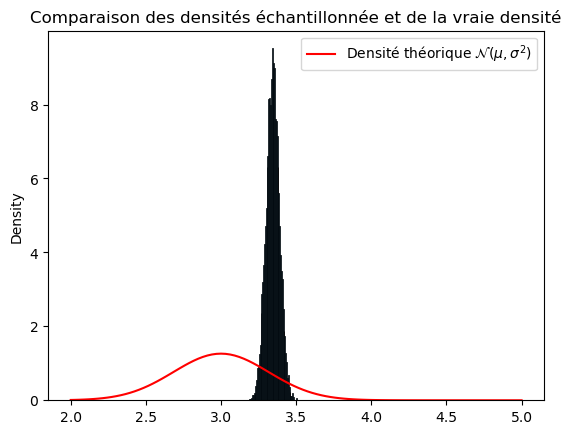

In [42]:
sns.histplot(X[1000:, 0], stat="density")
x = np.linspace(2, 5, 100)
plt.plot(x,
         stat.norm.pdf(x, loc=mu_vrai, scale=np.sqrt(sigma2_vrai)),
         label="Densité théorique $\\mathcal{N}(\\mu,\\sigma^2)$",
         c='red')
plt.legend()
plt.title("Comparaison des densités échantillonnée et de la vraie densité")

Text(0.5, 0.98, "Histogramme des échantillons tirés grâce à l'algorithme de Gibbs par blocs")

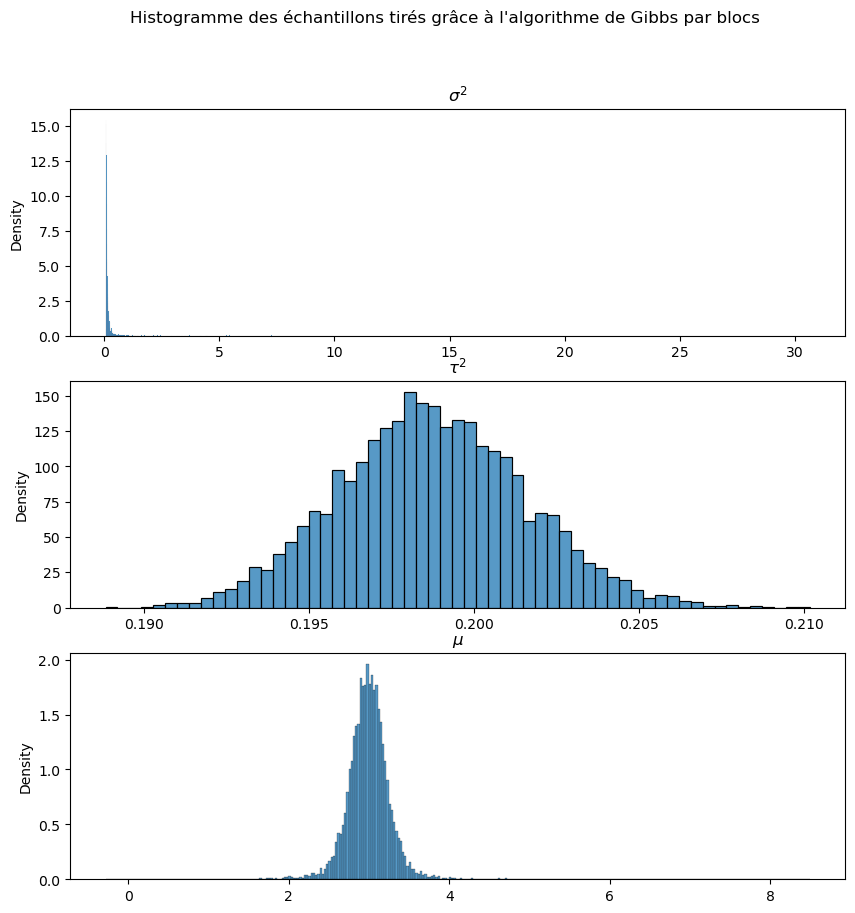

In [43]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
sns.histplot(sigma2[1000:], stat="density")
plt.title("$\\sigma^2$")

plt.subplot(3, 1, 2)
sns.histplot(tau2[1000:], stat="density")
plt.title("$\\tau^2$")

plt.subplot(3, 1, 3)
sns.histplot(mu[1000:], stat="density")
plt.title("$\\mu$")
plt.suptitle(
    "Histogramme des échantillons tirés grâce à l'algorithme de Gibbs par blocs"
)

In [44]:
print("Moyenne des sigma2 simulés : " + str(round(np.mean(sigma2[1000:]), 3)))
print("Vrai sigma2 : " + str(sigma2_vrai))
print("Différence entre les deux : " +
      str(np.abs(np.mean(sigma2[1000:]) - sigma2_vrai)))
print("\n")
print("Moyenne des tau2 simulés : " + str(round(np.mean(tau2[1000:]), 3)))
print("Vrai tau2 : " + str(tau2_vrai))
print("Différence entre les deux : " +
      str(np.abs(np.mean(tau2[1000:]) - tau2_vrai)))
print("\n")
print("Moyenne des mu simulés : " + str(round(np.mean(mu[1000:]), 3)))
print("Vrai mu : " + str(mu_vrai))
print("Différence entre les deux : " +
      str(np.abs(np.mean(mu[1000:]) - mu_vrai)))
print("\n")

Moyenne des sigma2 simulés : 0.163
Vrai sigma2 : 0.1
Différence entre les deux : 0.06329651628506805


Moyenne des tau2 simulés : 0.199
Vrai tau2 : 0.2
Différence entre les deux : 0.0012680988846333063


Moyenne des mu simulés : 2.991
Vrai mu : 3
Différence entre les deux : 0.008954625354445689




On compare les estimations réalisées par l'algorithme de Gibbs par blocs avec celles réalisées grâce à l'algorithme de Gibbs. On ne remarque pas une différence notable entre les deux. Les deux estimations réalisées sont de bonnes qualités malgré une garantie théorique d'avoir de meilleurs résultats en groupant les variables à échantillonner.